In [1]:
import pandas as pd
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

Create 20000 FGK dwarfs using the age distribution from Berger et al 2020a, with planets drawn from loguniform period distribution from 2 to 300 days, following the following cases:<br>

1) no difference between old and young stars, with 3 planets per star <br>
2) 10% of systems still intact (5 or 6 planets; < 2 Gyr old); 90% of systems disrupted (1 or 2 planets; > 2 Gyr) <br>

Why these two cases? Kepler data shows 7% (here we round to 10%) of systems are intact. We're using 2 Gyr instead of 1 Gyr like Berger et al in order to maintain the ~10%/90% proportion of sample sizes. ME FROM THE FUTURE: This is a wrong assumption. Skip to end of Case 2. <br>

#### The goal is to find out how many of these systems have transiting planets.

### Case 1

In [2]:
berger_kepler = pd.read_csv('berger_kepler_stellar17.csv')
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

[ 409 1918 2978 3679 3709 2930 1248  638  469  431  369  348  290  211
  153   85   53   38    9    4]
[0.14   0.5575 0.975  1.3925 1.81   2.2275 2.645  3.0625 3.48   3.8975
 4.315  4.7325 5.15   5.5675 5.985  6.4025 6.82   7.2375 7.655  8.0725
 8.49  ]


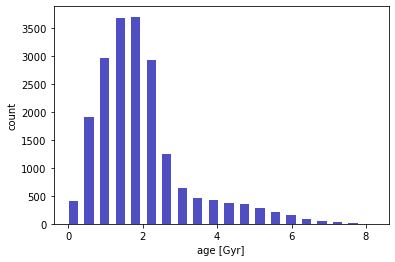

In [3]:
# age histogram for the 20000 FGK non-binary dwarfs from Berger et al 2020a with well-constrained ages
nbins = 20
age_hist, age_bin_edges = np.histogram(berger_kepler.iso_age, bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

Time for kernel density estimator? https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

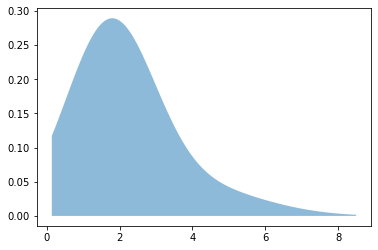

In [4]:
from sklearn.neighbors import KernelDensity

x = berger_kepler.iso_age
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian') # what else might be better?
kde.fit(x[:, None])

x_d = np.linspace(np.min(x),np.max(x),1000)
# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.show()

0.16134894568048957
0.13801577758850292
20000 [0.90896897 4.5364965  3.75081081 ... 2.3883984  1.9871972  1.5442042 ]


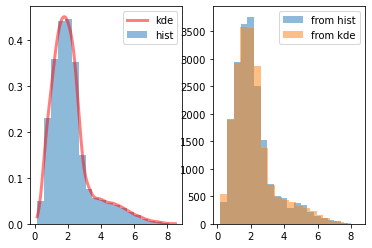

[0.90896897 4.5364965  3.75081081 ... 2.3883984  1.9871972  1.5442042 ]


In [5]:
# courtesy of https://stackoverflow.com/questions/17821458/random-number-from-histogram
from scipy.stats import gaussian_kde

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

#kdepdf = kde(x, x_d, bandwidth=0.1) # generate KDE model
#random_from_kde = generate_rand_from_pdf(kdepdf, x_d) # generate random data from KDE distribution

nbins = 20
def run_kde(data, draws):
    hist, bins = np.histogram(data, bins=100)

    x_grid = np.linspace(min(data), max(data), 1000)
    kdepdf = kde(data, x_grid, bandwidth=0.2) # generate KDE model
    random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
    print(len(random_from_kde), random_from_kde) # these are my star ages
    bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
    random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from the histogram

    plt.subplot(121)
    plt.hist(data, nbins, density=True, alpha=0.5, label='hist') # plot histogram of normalized data
    plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde') # plot KDE over normalized histogram
    plt.legend()
    plt.subplot(122)
    plt.hist(random_from_cdf, nbins, alpha=0.5, label='from hist') # plot histogram of data drawn from OG histogram
    plt.hist(random_from_kde, nbins, alpha=0.5, label='from kde') # plot histogram of data drawn from KDE
    plt.legend()
    plt.show()
    return random_from_kde, random_from_cdf
    
stars_age1_kde, stars_age1_cdf = run_kde(berger_kepler.iso_age, 20000)
print(stars_age1_kde)

60000 [ 98.38778431 124.74447937   9.98670987 ...  93.53699238  57.360616
   2.2400009 ]
[25429  7682  4593  3365  2624  2159  1849  1574  1455  1229  1130  1013
   929   885   754   734   677   686   645   588]
[  2.00019784  16.89939297  31.7985881   46.69778323  61.59697836
  76.49617349  91.39536862 106.29456375 121.19375888 136.09295401
 150.99214914 165.89134427 180.7905394  195.68973453 210.58892966
 225.48812479 240.38731992 255.28651504 270.18571017 285.0849053
 299.98410043]


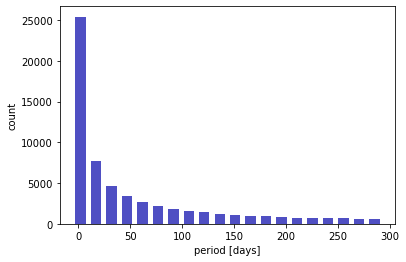

In [6]:
# host star follows age distribution of Berger et al 2020a
# 3 planets per star, with periods following loguniform distribution in [2, 300] days
from scipy.stats import loguniform

planets_per1 = loguniform.rvs(2, 300, size=60000)
print(len(planets_per1), planets_per1)

# histogram for 60000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per1, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

[2929 2979 2895 3001 3038 3025 2985 2986 3030 3142 2975 2993 3000 3085
 2994 3096 3034 2977 2897 2939]
[0.6932461  0.94377027 1.19429443 1.4448186  1.69534277 1.94586694
 2.19639111 2.44691528 2.69743945 2.94796362 3.19848779 3.44901195
 3.69953612 3.95006029 4.20058446 4.45110863 4.7016328  4.95215697
 5.20268114 5.45320531 5.70372947]


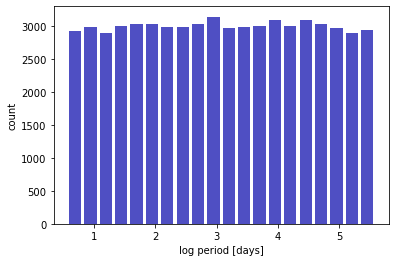

In [7]:
per_hist, per_bin_edges = np.histogram(np.log(planets_per1), bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 0.2, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("log period [days]")
plt.show()

### Case 2

1.1170311000339714
0.20889447103113198
2000 [0.70730731 0.7580981  0.70730731 ... 0.71419419 0.96814815 0.64016016]


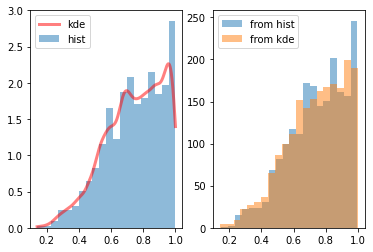

In [8]:
# 2000 systems with five or six planets and age <2 Gyr
# 18000 systems with one or two planets and age >2 Gyr
# should the age distribution be a truncated version of the KDE below and above 2 Gyr? yes
# going back and using a threshold of 1 Gyr like Berger et al 2020 b/c the proportion of young/old is more realistic
young = berger_kepler.loc[berger_kepler.iso_age <= 1.].iso_age
old = berger_kepler.loc[berger_kepler.iso_age > 1.].iso_age

stars_age2_young_kde, stars_age2_young_cdf = run_kde(young, 2000)

11000 [24.36645951 34.04753115 26.63386498 ...  6.7855396  46.43914808
 32.04541009]
[4656 1412  823  607  470  406  322  314  248  226  216  204  168  156
  151  145  133  134  105  104]
[  2.00042649  16.89847164  31.7965168   46.69456196  61.59260711
  76.49065227  91.38869743 106.28674258 121.18478774 136.08283289
 150.98087805 165.87892321 180.77696836 195.67501352 210.57305868
 225.47110383 240.36914899 255.26719415 270.1652393  285.06328446
 299.96132962]


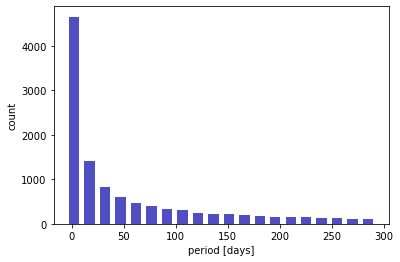

In [9]:
# generate five or six planets for each of the 2000 systems --> 11000 planets
planets_per2_young = loguniform.rvs(2, 300, size=11000)
print(len(planets_per2_young), planets_per2_young)

# histogram for 11000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per2_young, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

0.16776569556283707
0.14178034518473398
18000 [2.52247247 2.61232232 1.608999   ... 2.63478478 2.82197197 2.30533534]


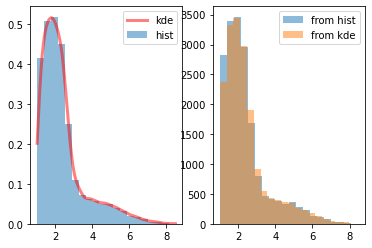

In [10]:
stars_age2_old_kde, stars_age2_old_cdf = run_kde(old, 18000)

27000 [  9.84748517  75.54312027  63.00598439 ...   5.40835428 134.63228153
 227.20379279]
[11535  3470  2047  1381  1191   949   791   710   587   586   506   465
   448   394   382   352   360   288   278   280]
[  2.00009803  16.89817788  31.79625772  46.69433756  61.59241741
  76.49049725  91.3885771  106.28665694 121.18473678 136.08281663
 150.98089647 165.87897632 180.77705616 195.675136   210.57321585
 225.47129569 240.36937553 255.26745538 270.16553522 285.06361507
 299.96169491]


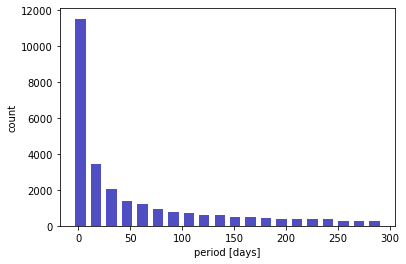

In [11]:
# generate one or two planets for each of the 18000 systems --> 27000 planets
planets_per2_young = loguniform.rvs(2, 300, size=27000)
print(len(planets_per2_young), planets_per2_young)

# histogram for 27000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per2_young, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

In [ ]:
"""# age histogram for the Case 2 2000 synthetic young and 18000 synthetic old stars drawn from Berger age distribution, 2 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age2_young)+list(stars_age2_old), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()
"""

Why da peak so high?? As we can see below, the 1 Gyr threshold is actually closer to the 10% split than the 2 Gyr threshold. So let's fall back to that.

In [12]:
# check percentage split of 1 Gyr age threshold vs 2 Gyr
print(len(berger_kepler.loc[berger_kepler.iso_age <= 1.]))
print(len(berger_kepler.loc[berger_kepler.iso_age > 1.]))
print(2514/len(berger_kepler))

print(len(berger_kepler.loc[berger_kepler.iso_age <= 2.]))
print(len(berger_kepler.loc[berger_kepler.iso_age > 2.]))
print(10814/len(berger_kepler))

# now check what threshold yields a 10%/90% young/old split
youngest_ten_percent = berger_kepler.iso_age.sort_values().head(int(len(berger_kepler)*(0.1))) # sort by ages and get first 10%
print(len(youngest_ten_percent))
print(youngest_ten_percent.tail())
print(len(stars_age1_kde[:int(len(stars_age1_kde) * 0.1)]))
print(stars_age1_kde[:int(len(stars_age1_kde) * 0.1)])


2514
17455
0.12589513746306777
10814
9155
0.5415393860483749
1996
11450    0.91
2020     0.92
11791    0.92
16754    0.92
919      0.92
Name: iso_age, dtype: float64
2000
[0.90896897 4.5364965  3.75081081 ... 0.55791792 1.7865966  5.75681682]


We'll go ahead and use 1 Gyr for now; we'll know from the transit simulation work whether a compact multi rate of 12.6% is consistent with the observed Kepler sample. Tuning this to get it to reproduce Kepler observations will be one of the next few steps anyway.

[ 333 1492 2548 3684 3811 3034 1606  768  511  459  408  371  308  245
  168  117   67   44   21    5]
[0.14258258 0.55171722 0.96085185 1.36998649 1.77912112 2.18825576
 2.59739039 3.00652503 3.41565966 3.82479429 4.23392893 4.64306356
 5.0521982  5.46133283 5.87046747 6.2796021  6.68873674 7.09787137
 7.50700601 7.91614064 8.32527528]


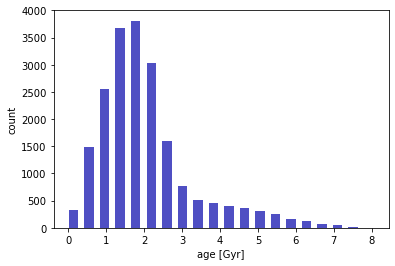

In [13]:
# age histogram for the Case 2 2000 synthetic young and 18000 synthetic old stars 
# drawn from two piecewise KDEs of the Berger age distribution
# 1 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age2_young_kde)+list(stars_age2_old_kde), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

0.16134894568048957
0.13801577758850292
5100
34900


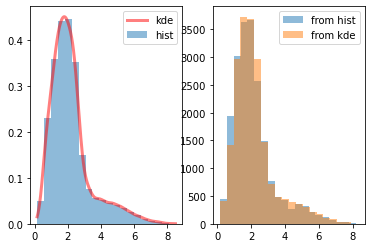

2000 18000


In [14]:
# maybe that was a bad idea to draw two separate piecewise KDEs
# instead, let's use the same KDE from Case 1 and just draw until we get 2000 young and 18000 old stars
def generate_rand_from_pdf_case2(pdf, x_grid, n_young, n_old):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(2*(n_young+n_old))
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    # select 2000 young from Case 1 KDE draw
    case2_young = [i for i in random_from_cdf if i <= 1.]
    print(len(case2_young))
    case2_young = random.sample(case2_young, 2000)
    # else select old
    case2_old = [i for i in random_from_cdf if i > 1.]
    print(len(case2_old))
    case2_old = random.sample(case2_old, 18000)
    return case2_young, case2_old

def run_kde_case2(data, draws):
    hist, bins = np.histogram(data, bins=100)

    x_grid = np.linspace(min(data), max(data), 1000)
    kdepdf = kde(data, x_grid, bandwidth=0.2) # generate KDE model
    random_from_kde_young, random_from_kde_old = generate_rand_from_pdf_case2(kdepdf, x_grid, 2000, 18000) # generate random data from KDE distribution
    #print(len(random_from_kde), random_from_kde) # these are my star ages
    bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
    random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from the histogram

    plt.subplot(121)
    plt.hist(data, nbins, density=True, alpha=0.5, label='hist') # plot histogram of normalized data
    plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde') # plot KDE over normalized histogram
    plt.legend()
    plt.subplot(122)
    plt.hist(random_from_cdf, nbins, alpha=0.5, label='from hist') # plot histogram of data drawn from OG histogram
    plt.hist(list(random_from_kde_young)+list(random_from_kde_old), nbins, alpha=0.5, label='from kde') # plot histogram of data drawn from KDE
    plt.legend()
    plt.show()
    return random_from_kde_young, random_from_kde_old

stars_age2_kde_young, stars_age2_kde_old = run_kde_case2(berger_kepler.iso_age, 20000)
print(len(stars_age2_kde_young), len(stars_age2_kde_old))

[ 416 1415 2959 3727 3684 2959 1474  714  489  447  397  360  305  220
  178  101   82   40   29    4]
[0.14835836 0.55666416 0.96496997 1.37327578 1.78158158 2.18988739
 2.59819319 3.006499   3.4148048  3.82311061 4.23141642 4.63972222
 5.04802803 5.45633383 5.86463964 6.27294545 6.68125125 7.08955706
 7.49786286 7.90616867 8.31447447]


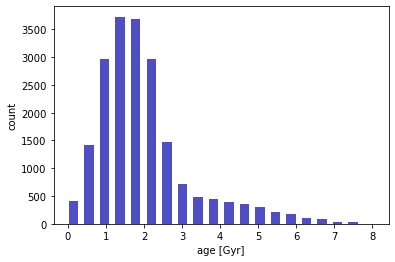

In [15]:
# age histogram for the Case 2 young and old stars, drawn from one continuous KDE fitted to Berger age distribution
# 1 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age2_kde_young)+list(stars_age2_kde_old), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

[ 547 1884 2933 3577 3570 2864 1385  713  489  437  388  317  283  231
  155  111   60   30   22    4]
[0.14       0.55415666 0.96831331 1.38246997 1.79662663 2.21078328
 2.62493994 3.0390966  3.45325325 3.86740991 4.28156657 4.69572322
 5.10987988 5.52403654 5.93819319 6.35234985 6.76650651 7.18066316
 7.59481982 8.00897648 8.42313313]


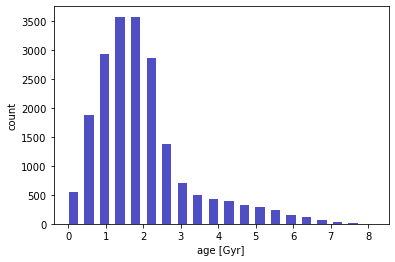

In [16]:
# age histogram for the Case 1 stars
# 1 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age1_kde), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

In [17]:
len([i for i in stars_age1_kde if i <= 1.])

2571

[ 409 1918 2978 3679 3709 2930 1248  638  469  431  369  348  290  211
  153   85   53   38    9    4]
[0.14   0.5575 0.975  1.3925 1.81   2.2275 2.645  3.0625 3.48   3.8975
 4.315  4.7325 5.15   5.5675 5.985  6.4025 6.82   7.2375 7.655  8.0725
 8.49  ]


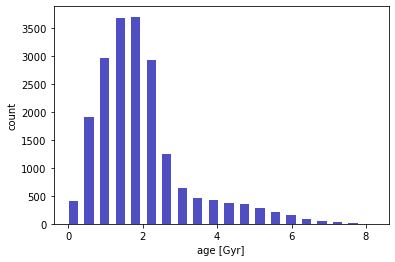

In [18]:
# age histogram for the 20000 FGK non-binary dwarfs from Berger et al 2020a with well-constrained ages
nbins = 20
age_hist, age_bin_edges = np.histogram(berger_kepler.iso_age, bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

So there's three ways I can go about this. Do I 1) sample from 2 piecewise KDEs fit onto the <1 and >1 parts of the Berger age distribution; 2) sample generously from a single KDE on the Berger age distribution and draw however much I need from the <1 and >1 portions; or 3) just use the KDE from Case 1? Also, should I really be sampling 10%/90% if the true threshold is at 12.6%? If I do that, I'm undersampling for the already smaller young sample. And if I don't do that, then I might as well take option 3, right? <br> <br>

Let's just use the synthetic stars from Case 1 for now and fall back on different sampling proportions if the transit work doesn't look right, as Sarah said.

### Transits

0.38690748364419597
0.13801577758850292
20000 [1.29106106 2.80369369 2.0881021  ... 1.16306907 2.43135335 1.84375375]


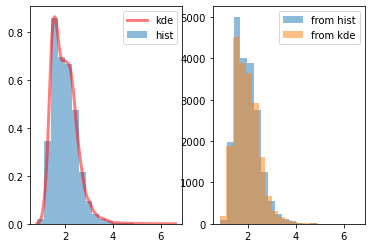

In [19]:
stars_radius_kde, stars_radius_cdf = run_kde(berger_kepler.iso_rad, 20000)

In [62]:
def transit_duration(P, r_star, r_planet, b, a, inc): # Winn 2011 Eqn 14
    arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)
    arg2 = (r_star / a) * (arg1 / np.sin(np.pi/2 - inc)) # was sin(i) but need to adjust for different index
    return (P / np.pi) * np.arcsin(arg2)

def transit_duration_paw(P, r_star, r_planet, b, a, inc): # https://www.paulanthonywilson.com/exoplanets/exoplanet-detection-techniques/the-exoplanet-transit-method/
    arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)
    arg2 = (r_star / a) * arg1 # the only difference is I don't divide by sin(i)
    return (P / np.pi) * np.arcsin(arg2)
    
def transit_duration_normalized_fab(P, r_star, r_planet, b): # Fabrycky 2012 unnamed eqn at the end of pg 8
    arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)
    return 2 * arg1 * r_star / (P**(-1./3))
    
def calculate_xi(tdur1, tdur2, P1, P2): # Fabrycky 2012 Eqn 1
    arg1 = tdur1/(P1**(1./3))
    arg2 = tdur2/(P2**(1./3))
    return arg1 / arg2

def day_to_year(per):
    return per/365.24 

def solar_radius_to_au(radius):
    return 0.00465047*radius

def earth_radius_to_au(radius):
    return 4.26352e-5*radius



In [116]:
# we use stars_age1_kde and planets_per1
# units are AU and year
# for each system, draw the midplane from uniform distribution, then draw planets' line of transit from Gaussian
# Case 2

midplanes = []
midplanes_degrees = []
inclinations = []
inclinations_degrees = []
planets_per_case2 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
planets_a_case2 = []
star_radius = []
impact_parameters = []
transit_status = []
transit_multiplicities = []
xi = []
xi_old = []
xi_young = []
sigma = np.pi/90 # two degrees, based on Fig 6 in Fabrycky 2012
sigma_degrees = 2

for r_star in stars_age1_kde:
    # star
    mu = np.random.uniform(-np.pi/2,np.pi/2,1) # create midplane for star 
    mu_degrees = np.random.uniform(-90,90,1) # more interpretable
    midplanes.append(mu)
    midplanes_degrees.append(mu_degrees)
    
    # planet
    r_planet = earth_radius_to_au(2.) # use two Earth radii; will make negligible difference
    if r_star <= 1.:
        num_planets = random.choice([5, 6]) # young system has 5 or 6 planets
        
        # draw 5 or 6 planet periods from loguniform distribution
        planet_per_case2 = loguniform.rvs(2, 300, size=num_planets) 
        planets_per_case2.append(planet_per_case2) 
        
        # inclinations for impact parameter formula
        inclination = np.random.normal(mu, sigma, num_planets) # need this for later
        inclinations.append(inclination) 
        inclinations_degrees.append(np.random.normal(mu_degrees, sigma_degrees, num_planets)) 
        
        # semi-major axes
        planet_a_case2 = day_to_year(planet_per_case2)**(2./3) # calculate semi-major axes based on simplified Kepler's Third Law
        planets_a_case2.append(planet_a_case2) 
    
        # calculate impact parameters
        b = (planet_a_case2 * np.sin(inclination))/solar_radius_to_au(r_star)
        impact_parameters.append(b)
        
        # calculate transit durations using Winn 2011 formula
        tdur = transit_duration(day_to_year(planet_per_case2), solar_radius_to_au(r_star), 
                                solar_radius_to_au(r_planet), b, planet_a_case2, inclination)
        #print("tdur: ", tdur)
        #print("tdur_paw: ", transit_duration_paw(planet_per_case2, r_star, r_planet, b, planet_a_case2, inclination))
        #print("tdur_fab: ", transit_duration_normalized_fab(planet_per_case2, r_star, r_planet, b))
        
        ### calculate xi for the system
        # periods and tdurs already match, so divide them to get normalized tdurs
        tdur_normalized = tdur/(day_to_year(planet_per_case2)**(1./3))
        
        # make sure I keep info on which tdur_normalized corresponds with which planet
        temp = pd.DataFrame({'period': planet_per_case2, 'tdur_normalized': tdur_normalized})
        temp = temp.dropna()
        
        # guarantee that xi will always have normalized transit durations of inner planet in numerator 
        temp = temp.sort_values(by='period') 
        #print(temp)
        tdur_normalized_combos = list(itertools.combinations(temp.tdur_normalized,2))
        #print("combos: ", tdur_normalized_combos)
        
        for combo in tdur_normalized_combos:
            xi.append(combo[0]/combo[1])
            xi_young.append(combo[0]/combo[1])

        # note individual planets' transit status
        transit_status.append([1 if np.abs(param) <= 1. else 0 for param in b])
        
        # transit check based on impact parameters
        transit_multiplicities.append(len([param for param in b if np.abs(param) <= 1.]))
        
    elif r_star > 1.:
        num_planets = random.choice([1, 2]) # old system has 1 or 2 planets
        
        # draw 1 or 2 planet periods from loguniform distribution
        planet_per_case2 = loguniform.rvs(2, 300, size=num_planets)
        planets_per_case2.append(planet_per_case2) # draw 5 or 6 planet periods from loguniform distribution
        
        # inclinations for impact parameter formula
        inclination = np.random.normal(mu, sigma, num_planets) # need this for later
        inclinations.append(inclination)
        inclinations_degrees.append(np.random.normal(mu_degrees, sigma_degrees, num_planets)) 
        
        # semi-major axes
        planet_a_case2 = day_to_year(planet_per_case2)**(2./3) # calculate semi-major axes based on simplified Kepler's Third Law
        planets_a_case2.append(planet_a_case2) 
        
        # calculate impact parameters
        b = (planet_a_case2 * np.sin(inclination))/solar_radius_to_au(r_star)
        impact_parameters.append(b)
        
        # calculate transit durations using Winn 2011 formula
        tdur = transit_duration(day_to_year(planet_per_case2), solar_radius_to_au(r_star),
                                solar_radius_to_au(r_planet), b, planet_a_case2, inclination)
        #print("tdur: ", tdur)
        #print("tdur_paw: ", transit_duration_paw(planet_per_case2, r_star, r_planet, b, planet_a_case2, inclination))
        #print("tdur_fab: ", transit_duration_normalized_fab(planet_per_case2, r_star, r_planet, b))
        
        ### calculate xi for the system
        # periods and tdurs already match, so divide them to get normalized tdurs
        tdur_normalized = tdur/(day_to_year(planet_per_case2)**(1./3))
        
        # make sure I keep info on which tdur_normalized corresponds with which planet
        temp = pd.DataFrame({'period': planet_per_case2, 'tdur_normalized': tdur_normalized})
        temp = temp.dropna()
        
        # guarantee that xi will always have normalized transit durations of inner planet in numerator 
        temp = temp.sort_values(by='period') 
        #print(temp)
        tdur_normalized_combos = list(itertools.combinations(temp.tdur_normalized,2))
        #print("combos: ", tdur_normalized_combos)
        
        for combo in tdur_normalized_combos:
            xi.append(combo[0]/combo[1])
            xi_old.append(combo[0]/combo[1])

        # note individual planets' transit status
        transit_status.append([1 if np.abs(param) <= 1. else 0 for param in b])
        
        # transit check based on impact parameters
        transit_multiplicities.append(len([param for param in b if np.abs(param) <= 1.]))
    
midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list

transits_dict = {'star_ages': stars_age1_kde, 'planet_periods': planets_per_case2, 'semi_major_axes': planets_a_case2,
                'midplane': midplanes, 'midplane_degrees': midplanes_degrees, 'planet_inclinations': inclinations,
                 'planet_inclinations_degrees': inclinations_degrees, 'star_radius': stars_radius_kde, 
                 'impact_parameters': impact_parameters, 'transit_status': transit_status, 
                 'transit_multiplicity': transit_multiplicities}

transits_case2 = pd.DataFrame(transits_dict)
print(transits_case2.head())

   star_ages                                     planet_periods  \
0   0.908969  [50.330773517250144, 18.354766795272106, 48.89...   
1   4.536496                               [26.955517719299515]   
2   3.750811                               [42.394296805371695]   
3   3.123934                               [5.6955303071198085]   
4   2.087497                                [5.773217449322095]   

                                     semi_major_axes  midplane  \
0  [0.2667903891910356, 0.13618011332616725, 0.26...  0.035962   
1                              [0.17594606657533354]  1.518040   
2                              [0.23795019658768318] -1.300214   
3                             [0.062417143395105235] -0.699366   
4                              [0.06298344153922927]  1.487208   

        midplane_degrees                                planet_inclinations  \
0    [8.023651185083622]  [0.0429106786088468, 0.0498172080886005, 0.020...   
1   [23.898287480673787]                  

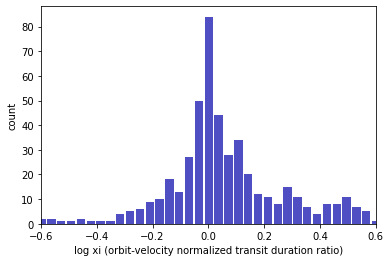

In [91]:
# histogram for xi occurrences...looks about right since I'd expect distribution to favor positive xi
# xi > 0 means inner planets still have lower b and longer transits even w/o considering period
# ie. mutual inclination matters

# should I cut xlim to -0.3, 0.3 before or after binning? before.
xi_hist, xi_bin_edges = np.histogram(np.log(xi), bins=125)
#print(xi_hist)
#print(xi_bin_edges)
plt.bar(xi_bin_edges[:-1], xi_hist, width = 0.03, color='#0504aa',alpha=0.7)
plt.xlim([-0.6, 0.6])
plt.ylabel("count")
plt.xlabel("log xi (orbit-velocity normalized transit duration ratio)")
plt.show()

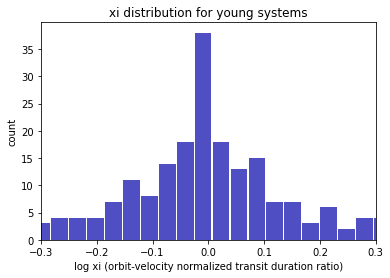

In [92]:
xi_hist, xi_bin_edges = np.histogram(np.log(xi_young), bins=125)
#print(xi_hist)
#print(xi_bin_edges)
plt.bar(xi_bin_edges[:-1], xi_hist, width = 0.03, color='#0504aa',alpha=0.7)
plt.xlim([-0.3, 0.3])
plt.ylabel("count")
plt.xlabel("log xi (orbit-velocity normalized transit duration ratio)")
plt.title("xi distribution for young systems")
plt.show()

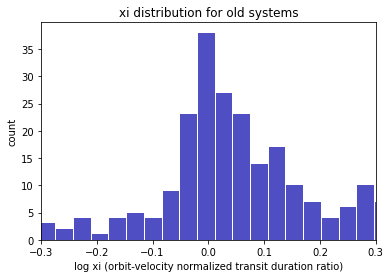

In [93]:
xi_hist, xi_bin_edges = np.histogram(np.log(xi_old), bins=125)
#print(xi_hist)
#print(xi_bin_edges)
plt.bar(xi_bin_edges[:-1], xi_hist, width = 0.03, color='#0504aa',alpha=0.7)
plt.xlim([-0.3, 0.3])
plt.ylabel("count")
plt.xlabel("log xi (orbit-velocity normalized transit duration ratio)")
plt.title("xi distribution for old systems")
plt.show()

In [66]:
transits_case2.loc[transits_case2.star_ages < 1.].head()

,star_ages,planet_periods,semi_major_axes,midplane,midplane_degrees,planet_inclinations,planet_inclinations_degrees,star_radius,impact_parameters,transit_multiplicity
0,0.908969,"[4.352744088923257, 5.1609716136147, 30.428730...","[0.05217428828686583, 0.05844787923196831, 0.1...",0.524603,[1.1084113104231648],"[0.480450869588433, 0.5388831937740537, 0.4670...","[3.8368805589615964, 4.360797604810161, -0.761...",1.291061,"[5.704543320743472, 7.095625636624942, 20.3173...",0
13,0.532843,"[2.506423699871468, 106.98818641431, 5.5562973...","[0.036111935792086276, 0.4410674354014772, 0.0...",-1.066921,[-72.75628683536546],"[-1.1143896391505421, -1.021197090108006, -1.0...","[-71.81822413248514, -72.62257787911653, -71.6...",1.192158,"[-13.081511517785051, -151.7827975215224, -21....",0
20,0.908969,"[86.55276650821166, 115.5785784537385, 6.46815...","[0.3829438329157511, 0.46437198314812256, 0.06...",-1.364176,[33.925873695375955],"[-1.3622986179467431, -1.364043575711372, -1.3...","[37.81244835378187, 37.6748534658236, 35.24802...",2.280090,"[-88.62990993039328, -107.51545127311738, -15....",0
24,0.683293,"[80.68928908718856, 6.944069196478775, 100.580...","[0.3654475348621234, 0.07123451479444055, 0.42...",-1.385968,[-67.94653941997541],"[-1.3147153853741465, -1.3725451269109157, -1....","[-66.68300932245528, -71.44496121529052, -65.8...",2.594252,"[-111.2557986778366, -21.9783614006367, -132.4...",0
36,0.549560,"[289.679688144369, 264.6286555437631, 9.053824...","[0.8568269935832821, 0.8066881750603287, 0.085...",-0.376495,[-49.51267063068633],"[-0.36620912977133424, -0.42718575402790443, -...","[-49.84137825779717, -50.31392121372471, -49.8...",1.954292,"[-120.049342018275, -130.77377111964535, -12.8...",0


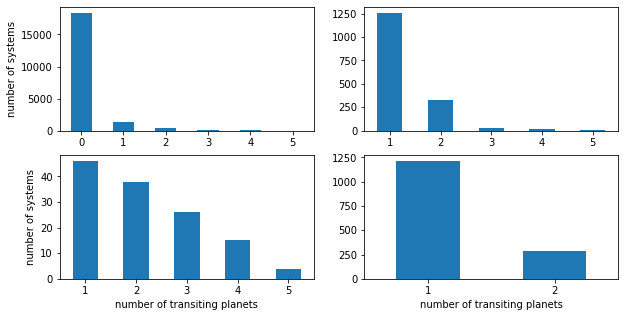

In [106]:
# plot transit multiplicity 
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(2, 2, 1)
transits_case2.transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.ylabel('number of systems')

# systems w/transiters only
ax = fig.add_subplot(2, 2, 2)
transits_case2.loc[transits_case2.transit_multiplicity > 0].transit_multiplicity.value_counts().plot(kind='bar', rot=0)

# young systems w/transiters
ax = fig.add_subplot(2, 2, 3)
transits_case2.loc[(transits_case2.star_ages < 1.) & (transits_case2.transit_multiplicity > 0)].transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.ylabel('number of systems')
plt.xlabel('number of transiting planets')

# old systems w/transiters
ax = fig.add_subplot(2, 2, 4)
transits_case2.loc[(transits_case2.star_ages > 1.) & (transits_case2.transit_multiplicity > 0)].transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.xlabel('number of transiting planets')

plt.show()

# young systems with one tranister shouldn't be the majority but should be overrepresented than expected
# this isn't the case...why?

In [72]:
print(len(transits_case2.loc[(transits_case2.star_ages > 1.)])) # total old'uns
print(len(transits_case2.loc[(transits_case2.star_ages < 1.)])) # total young'uns
print(len(transits_case2.loc[(transits_case2.star_ages > 1.) & (transits_case2.transit_multiplicity > 0)])) # old'uns w/transiters
print(len(transits_case2.loc[(transits_case2.star_ages < 1.) & (transits_case2.transit_multiplicity > 0)])) # young'uns w/transiters

# young systems w/transiters
print(len(transits_case2.loc[(transits_case2.star_ages < 1.) & (transits_case2.transit_multiplicity > 0)])/len(transits_case2.loc[(transits_case2.star_ages < 1.)]))
# old systems w/transiters
print(len(transits_case2.loc[(transits_case2.star_ages > 1.) & (transits_case2.transit_multiplicity > 0)])/len(transits_case2.loc[(transits_case2.star_ages > 1.)]))

# this is weird - we'd expect young systems, which have more close-in planets, to have more transiters on average
# maybe these differences disappear before the 1 Gyr threshold of young vs old? But then we'd expect them to be the same...
# or maybe the loguniform period draws aren't biased enough to get close-in-enough periods for transit effects to kick in. Same problem as above though...



17429
2571
1463
112
0.043562816024893036
0.08394055883871708


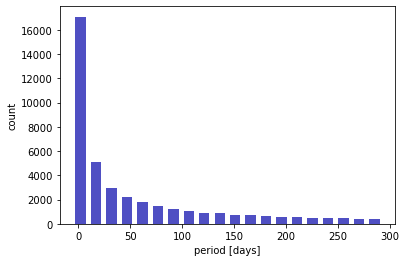

In [107]:
# plot period distribution to double check...yep checks out
per_hist, per_bin_edges = np.histogram(transits_case2.planet_periods.explode(), bins=nbins)
#print(per_hist)
#print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

In [117]:
# we use stars_age1_kde and planets_per1
# for each system, draw the midplane from uniform distribution, then draw planets' line of transit from Gaussian
# Case 1

midplanes = []
midplanes_degrees = []
inclinations = []
inclinations_degrees = []
planets_per_case1 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
planets_a_case1 = []
star_radius = []
impact_parameters = []
transit_status = []
transit_multiplicities = []
xi = []
sigma = np.pi/90 # two degrees, based on Fig 6 in Fabrycky 2012
sigma_degrees = 2

for r_star in stars_age1_kde:
    # star
    mu = np.random.uniform(-np.pi/2,np.pi/2,1) # create midplane for star
    mu_degrees = np.random.uniform(-90,90,1) # more interpretable
    midplanes.append(mu)
    midplanes_degrees.append(mu_degrees)
    
    # planet
    r_planet = earth_radius_to_au(2.) # use two Earth radii; will make negligible difference
    num_planets = 3

    # draw 3 planet periods from loguniform distribution
    planet_per_case1 = loguniform.rvs(2, 300, size=num_planets) 
    planets_per_case1.append(planet_per_case1) 

    # incliations for impact parameter formula
    inclination = np.random.normal(mu, sigma, num_planets) # need this for later
    inclinations.append(inclination) 
    inclinations_degrees.append(np.random.normal(mu_degrees, sigma_degrees, num_planets)) 

    # semi-major axes
    planet_a_case1 = day_to_year(planet_per_case1)**(2./3) # calculate semi-major axes based on simplified Kepler's Third Law
    planets_a_case1.append(planet_a_case1) 

    # calculate impact parameters
    b = (planet_a_case1 * np.sin(inclination))/solar_radius_to_au(r_star)
    impact_parameters.append(b)

    # calculate transit durations using Winn 2011 formula
    tdur = transit_duration(day_to_year(planet_per_case1), solar_radius_to_au(r_star),
                            solar_radius_to_au(r_planet), b, planet_a_case1, inclination)
    #print("tdur: ", tdur)
    #print("tdur_paw: ", transit_duration_paw(planet_per_case1, r_star, r_planet, b, planet_a_case1, inclination))
    #print("tdur_fab: ", transit_duration_normalized_fab(planet_per_case1, r_star, r_planet, b))

    ### calculate xi for the system
    # periods and tdurs already match, so divide them to get normalized tdurs
    tdur_normalized = tdur/(day_to_year(planet_per_case1)**(1./3))

    # make sure I keep info on which tdur_normalized corresponds with which planet
    temp = pd.DataFrame({'period': planet_per_case1, 'tdur_normalized': tdur_normalized})
    temp = temp.dropna()

    # guarantee that xi will always have normalized transit durations of inner planet in numerator 
    temp = temp.sort_values(by='period') 
    #print(temp)
    tdur_normalized_combos = list(itertools.combinations(temp.tdur_normalized,2))
    #print("combos: ", tdur_normalized_combos)

    for combo in tdur_normalized_combos:
        xi.append(combo[0]/combo[1])

    # note individual planets' transit status
    transit_status.append([1 if np.abs(param) <= 1. else 0 for param in b])
        
    # transit check based on impact parameters
    transit_multiplicities.append(len([param for param in b if np.abs(param) <= 1.]))
        
midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list

transits_dict = {'star_ages': stars_age1_kde, 'planet_periods': planets_per_case1, 'semi_major_axes': planets_a_case1,
                'midplane': midplanes, 'midplane_degrees': midplanes_degrees, 'planet_inclinations': inclinations,
                 'planet_inclinations_degrees': inclinations_degrees, 'star_radius': stars_radius_kde, 
                 'impact_parameters': impact_parameters, 'transit_status': transit_status,
                 'transit_multiplicity': transit_multiplicities}

transits_case1 = pd.DataFrame(transits_dict)
print(transits_case1.head())

   star_ages                                     planet_periods  \
0   0.908969  [4.389252347290102, 16.0602309307249, 233.4775...   
1   4.536496  [2.1108697828399294, 32.329287878977176, 24.61...   
2   3.750811  [65.08480399256543, 6.015016746427591, 12.9550...   
3   3.123934  [174.4433854454992, 153.32592974389328, 56.857...   
4   2.087497  [83.42547662387078, 5.909718348916829, 24.0580...   

                                     semi_major_axes  midplane  \
0  [0.05246562014902006, 0.12458018393415296, 0.7... -0.274956   
1  [0.03220490872323951, 0.198614919944633, 0.165... -1.026746   
2  [0.3166655687194633, 0.06473000955512796, 0.10... -0.475259   
3  [0.6110134658799475, 0.56064959810196, 0.28938...  1.297039   
4  [0.3736631250563442, 0.06397234923974714, 0.16... -0.281160   

        midplane_degrees                                planet_inclinations  \
0  [-48.116495996220166]  [-0.23745559944308853, -0.3149523118158325, -0...   
1   [-4.280033675026829]  [-1.000175077052

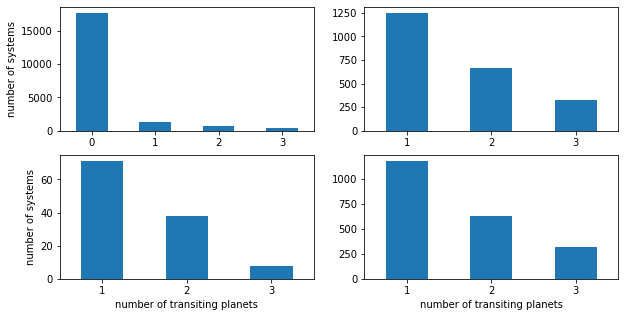

In [108]:
# plot transit multiplicity 
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(2, 2, 1)
transits_case1.transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.ylabel('number of systems')

# systems w/transiters only
ax = fig.add_subplot(2, 2, 2)
transits_case1.loc[transits_case1.transit_multiplicity > 0].transit_multiplicity.value_counts().plot(kind='bar', rot=0)

# young systems w/transiters
ax = fig.add_subplot(2, 2, 3)
transits_case1.loc[(transits_case1.star_ages < 1.) & (transits_case1.transit_multiplicity > 0)].transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.ylabel('number of systems')
plt.xlabel('number of transiting planets')

# old systems w/transiters
ax = fig.add_subplot(2, 2, 4)
transits_case1.loc[(transits_case1.star_ages > 1.) & (transits_case1.transit_multiplicity > 0)].transit_multiplicity.value_counts().plot(kind='bar', rot=0)
plt.xlabel('number of transiting planets')

plt.show()

# control checks out at least

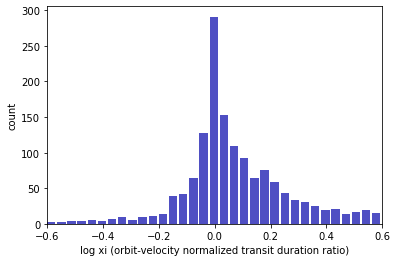

In [110]:
# histogram for xi occurrences for Case 1 (control)
xi_hist, xi_bin_edges = np.histogram(np.log(xi), bins=125)
plt.bar(xi_bin_edges[:-1], xi_hist, width = 0.03, color='#0504aa',alpha=0.7)
plt.xlim([-0.6, 0.6])
plt.ylabel("count")
plt.xlabel("log xi (orbit-velocity normalized transit duration ratio)")
plt.show()

#### Why do my older systems have a greater proportion of transiters than my young ones?

40303
2087


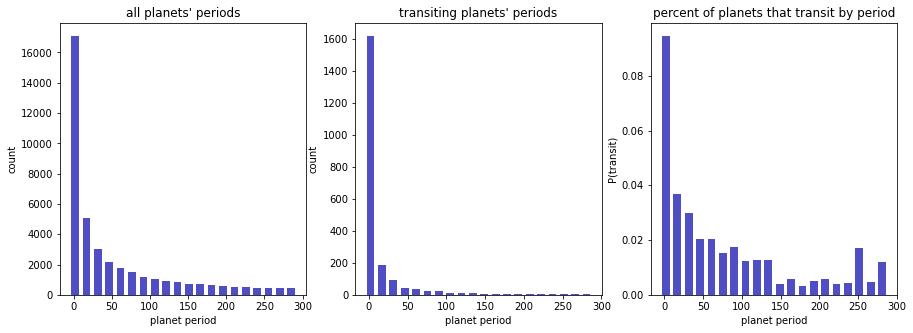

In [194]:
# let's plot P(transit) as a function of period
# proxy: histogram of transits per period bin, divided by histogram of periods

# explode lists for planet_periods and transit_status to get individual planets' period and transit status
transits_case2_period_status = transits_case2[['planet_periods', 'transit_status']].apply(pd.Series.explode).reset_index()
print(len(transits_case2_period_status))

# keep only rows with transit_status == 1
transits_case2_period_status = transits_case2_period_status.loc[transits_case2_period_status.transit_status == 1]
print(len(transits_case2_period_status))

# plot histogram
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("planet period")
plt.title("all planets' periods")

ax = fig.add_subplot(1, 3, 2)
ptransit_hist, ptransit_bin_edges = np.histogram(transits_case2_period_status.planet_periods, bins=nbins)
plt.bar(ptransit_bin_edges[:-1], ptransit_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("planet period")
plt.title("transiting planets' periods")

# calculate probability of transit by dividing counts per bin by corresponding counts in period histogram above
ax = fig.add_subplot(1, 3, 3)
plt.bar(ptransit_bin_edges[:-1], ptransit_hist/per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("P(transit)")
plt.xlabel("planet period")
plt.title("percent of planets that transit by period")
plt.show()

#transits_case2_period_status['ptransit'] = 


26146
1782


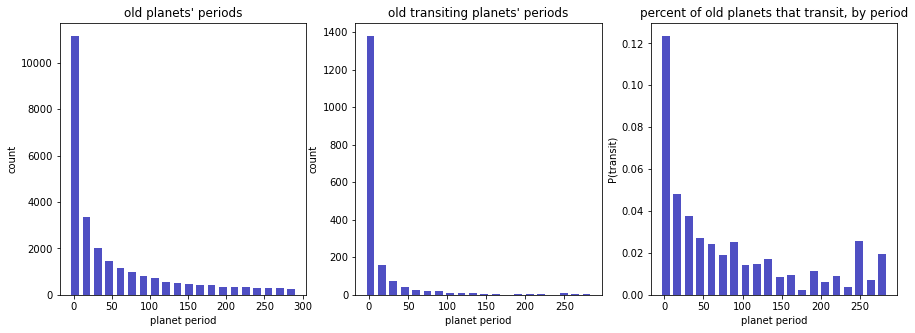

In [197]:
# again for old

# explode lists for planet_periods and transit_status to get individual planets' period and transit status
transits_case2_old = transits_case2.loc[transits_case2.star_ages > 1.]
transits_case2_period_status = transits_case2_old[['planet_periods', 'transit_status']].apply(pd.Series.explode).reset_index()
print(len(transits_case2_period_status))

# keep only rows with transit_status == 1
transits_case2_period_status = transits_case2_period_status.loc[transits_case2_period_status.transit_status == 1]
print(len(transits_case2_period_status))

### plot histograms
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 3, 1)
# calculate probability of transit by dividing counts per bin by corresponding counts in period histogram above
per_old_hist, per_old_bin_edges = np.histogram(transits_case2_old.planet_periods.explode(), bins=nbins)
plt.bar(per_old_bin_edges[:-1], per_old_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("planet period")
plt.title("old planets' periods")

ax = fig.add_subplot(1, 3, 2)
ptransit_hist, ptransit_bin_edges = np.histogram(transits_case2_period_status.planet_periods, bins=nbins)
plt.bar(ptransit_bin_edges[:-1], ptransit_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("planet period")
plt.title("old transiting planets' periods")

ax = fig.add_subplot(1, 3, 3)
plt.bar(ptransit_bin_edges[:-1], ptransit_hist/per_old_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("P(transit)")
plt.xlabel("planet period")
plt.title("percent of old planets that transit, by period")
plt.show()



In [139]:
1782/26146

0.06815574083989903

14157
305


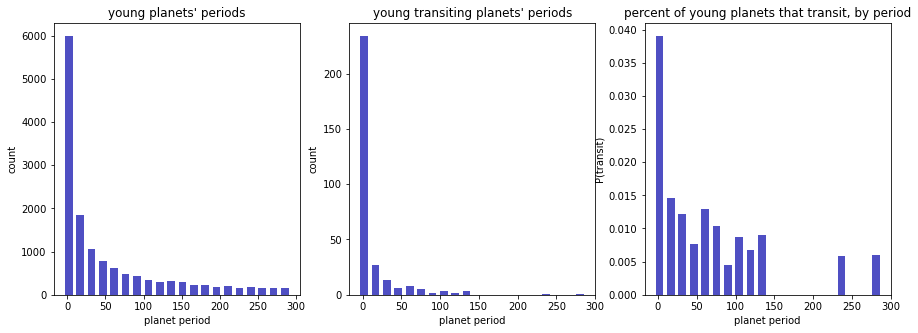

In [196]:
# and for young

# explode lists for planet_periods and transit_status to get individual planets' period and transit status
transits_case2_young = transits_case2.loc[transits_case2.star_ages < 1.]
transits_case2_period_status = transits_case2_young[['planet_periods', 'transit_status']].apply(pd.Series.explode).reset_index()
print(len(transits_case2_period_status))

# keep only rows with transit_status == 1
transits_case2_period_status = transits_case2_period_status.loc[transits_case2_period_status.transit_status == 1]
print(len(transits_case2_period_status))

### plot histogram
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
# calculate probability of transit by dividing counts per bin by corresponding counts in period histogram above
per_young_hist, per_young_bin_edges = np.histogram(transits_case2_young.planet_periods.explode(), bins=nbins)
plt.bar(per_young_bin_edges[:-1], per_young_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("planet period")
plt.title("young planets' periods")

ax = fig.add_subplot(1, 3, 2)
ptransit_hist, ptransit_bin_edges = np.histogram(transits_case2_period_status.planet_periods, bins=nbins)
plt.bar(ptransit_bin_edges[:-1], ptransit_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("planet period")
plt.title("young transiting planets' periods")

ax = fig.add_subplot(1, 3, 3)
plt.bar(ptransit_bin_edges[:-1], ptransit_hist/per_young_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("P(transit)")
plt.xlabel("planet period")
plt.title("percent of young planets that transit, by period")
plt.show()


In [140]:
305/14157

0.02154411245320336

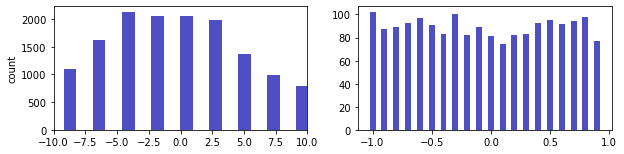

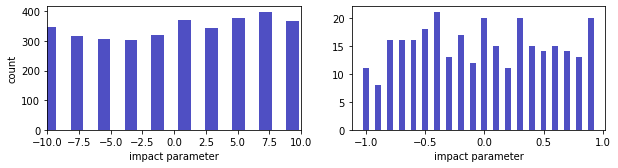

In [169]:
# how about for impact parameter?
# old
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(2, 2, 1)
b_old_hist, b_old_bin_edges = np.histogram(transits_case2_old.impact_parameters.explode(), bins=150)
plt.bar(b_old_bin_edges[:-1], b_old_hist, width = 1, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlim([-10, 10])

ax = fig.add_subplot(2, 2, 2)
b_old_hist, b_old_bin_edges = np.histogram(transits_case2_old.impact_parameters.explode().loc[np.abs(transits_case2_old.impact_parameters.explode()) <= 1.], bins=nbins)
plt.bar(b_old_bin_edges[:-1], b_old_hist, width = 0.05, color='#0504aa',alpha=0.7)

# young 
ax = fig.add_subplot(2, 2, 3)
b_young_hist, b_young_bin_edges = np.histogram(transits_case2_young.impact_parameters.explode(), bins=1000)
plt.bar(b_young_bin_edges[:-1], b_young_hist, width = 1, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("impact parameter")
plt.xlim([-10, 10])

ax = fig.add_subplot(2, 2, 4)
b_young_hist, b_young_bin_edges = np.histogram(transits_case2_young.impact_parameters.explode().loc[np.abs(transits_case2_young.impact_parameters.explode()) <= 1.], bins=nbins)
plt.bar(b_young_bin_edges[:-1], b_young_hist, width = 0.05, color='#0504aa',alpha=0.7)
plt.xlabel("impact parameter")

plt.show()

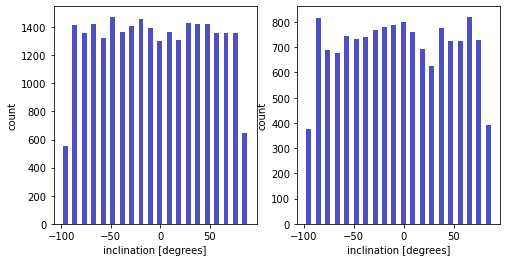

In [195]:
# how about for inclination?
# old
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
b_old_hist, b_old_bin_edges = np.histogram(transits_case2_old.planet_inclinations_degrees.explode(), bins=nbins)
plt.bar(b_old_bin_edges[:-1], b_old_hist, width = 5, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("inclination [degrees]")
#plt.xlim([-10, 10])

# young 
ax = fig.add_subplot(1, 2, 2)
b_young_hist, b_young_bin_edges = np.histogram(transits_case2_young.planet_inclinations_degrees.explode(), bins=nbins)
plt.bar(b_young_bin_edges[:-1], b_young_hist, width = 5, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("inclination [degrees]")
#plt.xlim([-10, 10])

plt.show()

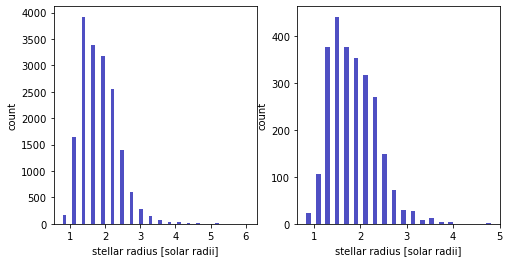

In [184]:
# I'm really running out of ideas now...what's left? R_star? a??
### stellar radius
# old
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
b_old_hist, b_old_bin_edges = np.histogram(transits_case2_old.star_radius.explode(), bins=nbins)
plt.bar(b_old_bin_edges[:-1], b_old_hist, width = 0.1, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("stellar radius [solar radii]")
#plt.xlim([-10, 10])

# young 
ax = fig.add_subplot(1, 2, 2)
b_young_hist, b_young_bin_edges = np.histogram(transits_case2_young.star_radius.explode(), bins=nbins)
plt.bar(b_young_bin_edges[:-1], b_young_hist, width = 0.1, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("stellar radius [solar radii]")
#plt.xlim([-10, 10])

plt.show()

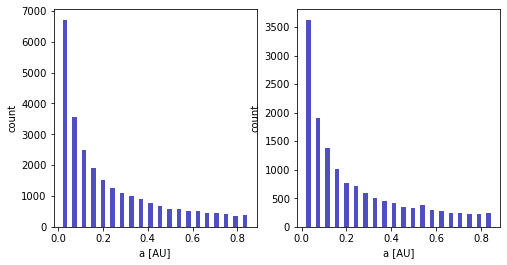

In [188]:
### semi-major axes
# old
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
b_old_hist, b_old_bin_edges = np.histogram(transits_case2_old.semi_major_axes.explode(), bins=nbins)
plt.bar(b_old_bin_edges[:-1], b_old_hist, width = 0.02, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("a [AU]")
#plt.xlim([-10, 10])

# young 
ax = fig.add_subplot(1, 2, 2)
b_young_hist, b_young_bin_edges = np.histogram(transits_case2_young.semi_major_axes.explode(), bins=nbins)
plt.bar(b_young_bin_edges[:-1], b_young_hist, width = 0.02, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("a [AU]")
#plt.xlim([-10, 10])

plt.show()